In [1]:
import os
from importlib.resources import files
import time
import pickle

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3D

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import SecondGeometry, LinearField
from learn_embedding.utils import *

## Load Dataset

In [2]:
dim = 3
num_train = 4
num_samples = 1000

In [4]:
dataset = "robotic_demo"
with open("../learn_embedding/data/roboticdemos/"+ dataset +".pkl", 'rb') as fp:
    data = pickle.load(fp)

train_x = np.empty((0, 2*dim))
train_y = np.empty((0, dim))
test_x = np.empty((0, 2*dim))
test_y = np.empty((0, dim))
pos, vel, acc = [], [], []

for count, demo in enumerate(data):
    # extract end-effector position and velocity
    dt = demo['dt']
    p = demo['ee_pose'][:, :3]
    v = demo['ee_velocity'][:, :3]

    # smooth
    p = DataProcess.smooth(p, 10, 2)
    v = DataProcess.smooth(v, 10, 2)

    # reconstruct acceleration
    a = DataProcess.smooth(v, 10, 2, deriv=1, delta=dt, mode='interp', cval=0.0)
    # a = (v[1:] - v[:-1])/dt

    # subsample
    idx = DataProcess.subsample(p, num_samples=num_samples)
    p, v, a = p[idx], v[idx], a[idx]

    # center
    p -= p[-1]

    # zero velocity last sample
    v[-1] = np.zeros(dim)

    # zero acceleration last sample
    a[-1] = np.zeros(dim)

    # train/test set
    if count < num_train:
        train_x = np.append(train_x, np.concatenate((p,v),axis=1), axis=0)
        train_y = np.append(train_y, a, axis=0)
    else:
        test_x = np.append(test_x, np.concatenate((p,v),axis=1), axis=0)
        test_y = np.append(test_y, a, axis=0)

    # store
    pos.append(p)
    vel.append(v)
    acc.append(a)

## Torch Configuration

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device).requires_grad_(True)
test_y = torch.from_numpy(test_y).float().to(device)

## Create Model

In [6]:
torch.manual_seed(1337)
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
approximator = FeedForward(dim, [64], 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)
dissipation = SPD(dim)

attractor = train_x[-1, :dim]

field = LinearField(attractor, Spherical(0.5, False))

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# model = TorchHelpel.load(model,)
model.velocity_embedding = False

## Train

In [7]:
trainer = Trainer(model, train_x, train_y)
trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
# trainer.loss = torch.nn.MSELoss()
trainer.loss = torch.nn.SmoothL1Loss()
trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=10000)
# trainer.train()
# TorchHelpel.save(model,)

## Test

In [8]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2

### Vector Field & Streamlines

Text(0.5, 0.5, '$x^3$')

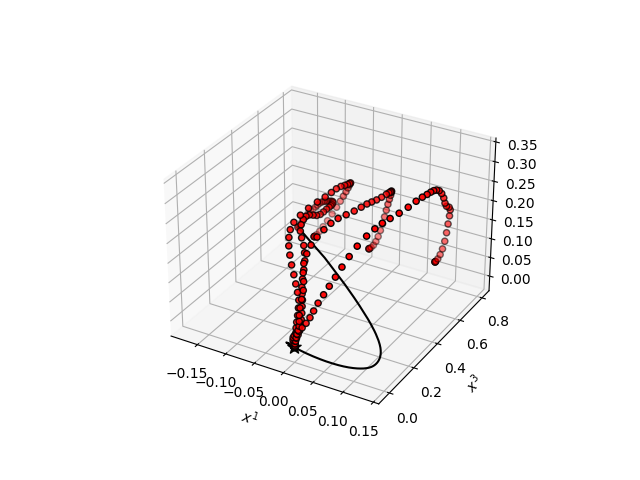

In [9]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale)).to(device)
# embedding.local_deformation = phi

x0 = train_x[0, :dim].unsqueeze(0)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=10, dt=0.01).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111,  projection="3d")
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], streamlines[:, i, 2], color='k')
ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], train_x.cpu().detach()[::10, 2], s=20, edgecolors='k', c='red')
ax.scatter(train_x.cpu().detach()[-1, 0], train_x.cpu().detach()[-1, 1], train_x.cpu().detach()[-1, 2], s=100, edgecolors='k', c='yellow', marker="*")
ax.set_xlabel('$x^1$')
ax.set_ylabel('$x^2$')
ax.set_ylabel('$x^3$')